# 🍛 Fine-Tuning LLM untuk Chatbot Kuliner & Sejarah Jogja

**UAS Deep Learning 2025**

---

## 👥 Anggota Kelompok
| No | Nama | NIM |
|----|------|-----|
| 1 | Michael Ardiyanto | 230712326 |
| 2 | Naomi Nadya Kinasih | 230712412 |
| 3 | Jovita Maria E.H | 230712428 |

**Kelas:** A

---

## 📋 Daftar Isi
1. Import Library
2. Dataset & Data Preparation
3. Tokenization & Prompt Formatting
4. Load Pre-trained Model
5. LoRA Configuration
6. Training Loop
7. Model Evaluation (LLM-based Scoring)
8. Model Prediction & Save Results
9. Save & Upload Model
10. Deployment ke Hugging Face Spaces

---
## 1. Import Library

In [1]:
# Install dependencies
!pip install transformers datasets peft lion-pytorch accelerate sentencepiece -q
!pip install huggingface_hub -q

In [2]:
import os
import json
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, AutoModelForCausalLM, get_cosine_schedule_with_warmup
from datasets import Dataset
from peft import LoraConfig, get_peft_model
from lion_pytorch import Lion

print("✅ Semua library berhasil diimport!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

✅ Semua library berhasil diimport!
PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-40GB


---
## 2. Dataset & Data Preparation

Dataset berisi pasangan instruction-output tentang kuliner dan sejarah Yogyakarta.

In [3]:
# Upload dataset ke Colab terlebih dahulu
# File yang dibutuhkan: dataset_jogja_train.json dan dataset_jogja_test.json

from google.colab import files
print("📤 Upload file dataset_jogja_train.json dan dataset_jogja_test.json")
# uploaded = files.upload()  # Uncomment jika perlu upload

📤 Upload file dataset_jogja_train.json dan dataset_jogja_test.json


In [4]:
# Load Dataset
print("📂 Memuat dataset...")

with open('dataset_jogja_train.json', 'r', encoding='utf-8') as f:
    train_data = json.load(f)

with open('dataset_jogja_test.json', 'r', encoding='utf-8') as f:
    test_data = json.load(f)

print(f"✅ Dataset berhasil dimuat!")
print(f"   Train: {len(train_data)} samples")
print(f"   Test: {len(test_data)} samples")

📂 Memuat dataset...
✅ Dataset berhasil dimuat!
   Train: 634 samples
   Test: 112 samples


In [5]:
# Cek struktur dataset (instruction-input-output)
print("📋 Contoh data training:")
print("="*60)

for i in range(3):
    print(f"\nSample {i+1}:")
    print(f"  Instruction: {train_data[i]['instruction']}")
    print(f"  Input: {train_data[i].get('input', '-')}")
    print(f"  Output: {train_data[i]['output'][:100]}...")

📋 Contoh data training:

Sample 1:
  Instruction: Mengapa organisasi otonom seperti Aisyiyah penting?
  Input: -
  Output: Memberikan wadah perempuan untuk terlibat aktif dalam pendidikan dan dakwah....

Sample 2:
  Instruction: Apa contoh kampung prajurit di luar benteng?
  Input: -
  Output: Wirobrajan, Dhaengan, Patangpuluhan, Jogokaryan, Prawirotaman, Nyutran, Ketanggungan, Mantrijeron....

Sample 3:
  Instruction: Mengapa istilah sapaan sangat rinci dalam budaya Jawa?
  Input: -
  Output: Untuk menunjukkan hormat dan posisi sosial kerabat....


In [6]:
# Convert ke HuggingFace Dataset
train_dataset = Dataset.from_list(train_data)
test_dataset = Dataset.from_list(test_data)

# Buat DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    drop_last=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False
)

print(f"✅ DataLoader siap!")
print(f"   Train batches: {len(train_loader)}")
print(f"   Test batches: {len(test_loader)}")

✅ DataLoader siap!
   Train batches: 317
   Test batches: 112


---
## 3. Tokenization & Prompt Formatting

Menggunakan template prompt khusus untuk model Gemma dengan format chat.

In [7]:
# Template Prompt untuk Gemma
template_without_answer = "<start_of_turn>user\n{question}<end_of_turn>\n<start_of_turn>model\n"
template_with_answer = template_without_answer + "{answer}<end_of_turn>\n"

# Contoh penggunaan template
print("📝 Contoh format prompt:")
print("="*60)
print(template_with_answer.format(
    question="Apa itu gudeg?",
    answer="Gudeg adalah makanan khas Yogyakarta berbahan dasar nangka muda."
))

📝 Contoh format prompt:
<start_of_turn>user
Apa itu gudeg?<end_of_turn>
<start_of_turn>model
Gudeg adalah makanan khas Yogyakarta berbahan dasar nangka muda.<end_of_turn>



In [8]:
# Load Tokenizer
model_id = "unsloth/gemma-2-2b-it"

print("🔄 Memuat tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

print(f"✅ Tokenizer siap!")
print(f"   Vocab size: {len(tokenizer.get_vocab())}")
print(f"   Pad token: {tokenizer.pad_token}")

🔄 Memuat tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

✅ Tokenizer siap!
   Vocab size: 256000
   Pad token: <eos>


In [9]:
# Test tokenisasi
sample_text = "Apa rekomendasi makanan di Jogja?"
tokens = tokenizer.encode(sample_text, return_tensors="pt")

print(f"Original: {sample_text}")
print(f"Token IDs: {tokens[0].tolist()}")
print(f"Decoded: {tokenizer.decode(tokens[0])}")

Original: Apa rekomendasi makanan di Jogja?
Token IDs: [2, 46719, 189923, 35041, 751, 62064, 1663, 235336]
Decoded: <bos>Apa rekomendasi makanan di Jogja?


In [10]:
# Custom Collate Function untuk padding
def collate_fn(batch):
    """
    Custom collate function untuk memproses batch data
    dengan padding dan attention mask
    """
    texts = []
    for item in batch:
        text = template_with_answer.format(
            question=item['instruction'],
            answer=item['output']
        )
        texts.append(text)

    encoded = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    return encoded

print("✅ Collate function siap!")

✅ Collate function siap!


---
## 4. Load Pre-trained Model

Menggunakan model Gemma 2B yang sudah di-pretrain.

In [11]:
# Load Model
print("🔄 Memuat model Gemma 2B...")
print("⏳ Ini membutuhkan waktu beberapa menit...")

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto"
)

print(f"✅ Model berhasil dimuat!")
print(f"   Model: {model_id}")
print(f"   Device: {model.device}")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")

🔄 Memuat model Gemma 2B...
⏳ Ini membutuhkan waktu beberapa menit...


config.json:   0%|          | 0.00/913 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/5.23G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

✅ Model berhasil dimuat!
   Model: unsloth/gemma-2-2b-it
   Device: cuda:0
   Parameters: 2,614,341,888


In [12]:
# Test inference sebelum fine-tuning
print("🧪 Test model sebelum fine-tuning:")
print("="*60)

test_question = "Apa itu gudeg?"
prompt = template_without_answer.format(question=test_question)
tokens = tokenizer.encode(prompt, return_tensors="pt").to(model.device)

with torch.no_grad():
    output = model.generate(tokens, max_new_tokens=50)

response = tokenizer.decode(output[0], skip_special_tokens=True)
print(f"Q: {test_question}")
print(f"A: {response.split('model')[-1].strip() if 'model' in response else response}")

🧪 Test model sebelum fine-tuning:
Q: Apa itu gudeg?
A: Gudeg adalah makanan khas Yogyakarta, Indonesia. 

**Deskripsi:**

* **Bahan utama:** Gudeg terbuat dari **sayur dan daging yang dimasak dengan santan dan bumbu khas**. 
* **Sayuran:** Biasanya, gu


---
## 5. LoRA Configuration

Menggunakan LoRA (Low-Rank Adaptation) untuk fine-tuning yang efisien.

In [13]:
# Konfigurasi LoRA
lora_config = LoraConfig(
    r=32,                    # Rank
    lora_alpha=64,           # Alpha = 2 × rank
    lora_dropout=0.05,       # Dropout
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ],
    bias="none",
    task_type="CAUSAL_LM"
)

# Apply LoRA ke model
model = get_peft_model(model, lora_config)

print("✅ LoRA berhasil diterapkan!")
model.print_trainable_parameters()

✅ LoRA berhasil diterapkan!
trainable params: 41,533,440 || all params: 2,655,875,328 || trainable%: 1.5638


In [14]:
# Training Configuration
NUM_EPOCHS = 3
ACCUMULATION_STEPS = 8
LEARNING_RATE = 2e-4
WARMUP_RATIO = 0.1

total_steps = (len(train_loader) // ACCUMULATION_STEPS) * NUM_EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

# Optimizer & Scheduler
optimizer = Lion(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print("📊 Training Configuration:")
print(f"   Epochs: {NUM_EPOCHS}")
print(f"   Total steps: {total_steps}")
print(f"   Warmup steps: {warmup_steps}")
print(f"   Batch size: 2")
print(f"   Accumulation steps: {ACCUMULATION_STEPS}")
print(f"   Effective batch size: {2 * ACCUMULATION_STEPS}")
print(f"   Learning rate: {LEARNING_RATE}")

📊 Training Configuration:
   Epochs: 3
   Total steps: 117
   Warmup steps: 11
   Batch size: 2
   Accumulation steps: 8
   Effective batch size: 16
   Learning rate: 0.0002


---
## 6. Training Loop

In [15]:
# Loss Function
def compute_loss(model, tokens, mask, max_length=512):
    """
    Hitung loss hanya untuk bagian JAWABAN (bukan pertanyaan)
    """
    tokens = tokens[:, :max_length]
    mask = mask[:, :max_length]

    x = tokens[:, :-1]
    y = tokens[:, 1:]
    mask = mask[:, 1:]

    logits = model(x).logits

    loss = F.cross_entropy(
        logits.reshape(-1, logits.size(-1)),
        y.reshape(-1),
        reduction="none"
    )

    masked_loss = loss * mask.reshape(-1).float()
    return masked_loss.sum() / mask.sum().clamp(min=1)

print("✅ Loss function siap!")

✅ Loss function siap!


In [16]:
# Training Loop
print("="*60)
print("🚀 MEMULAI TRAINING")
print("="*60)

model.train()
optimizer.zero_grad()

losses = []
global_step = 0
best_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    print(f"\n📖 EPOCH {epoch+1}/{NUM_EPOCHS}")
    print("-"*60)

    epoch_losses = []
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    for i, batch in enumerate(pbar):
        # Format data
        q = batch["instruction"][0]
        a = batch["output"][0]
        text = template_with_answer.format(question=q, answer=a)

        # Tokenize
        encoded = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=512,
            padding=False
        )

        tokens = encoded["input_ids"].to(model.device)

        # Create answer mask
        answer_start = text.find("<start_of_turn>model\n") + len("<start_of_turn>model\n")
        answer_tokens_start = len(tokenizer.encode(text[:answer_start])) - 1
        mask = torch.zeros_like(tokens, dtype=torch.bool)
        mask[0, answer_tokens_start:] = True

        # Compute loss
        loss = compute_loss(model, tokens, mask)
        loss = loss / ACCUMULATION_STEPS
        loss.backward()

        epoch_losses.append(loss.item() * ACCUMULATION_STEPS)

        # Update weights
        if (i + 1) % ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            global_step += 1

            avg_loss = np.mean(epoch_losses[-ACCUMULATION_STEPS:])
            losses.append(avg_loss)

            if avg_loss < best_loss:
                best_loss = avg_loss

            pbar.set_postfix({"loss": f"{avg_loss:.4f}", "best": f"{best_loss:.4f}"})

    # Epoch summary
    epoch_avg_loss = np.mean(epoch_losses)
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"   Average Loss: {epoch_avg_loss:.4f}")
    print(f"   Best Loss: {best_loss:.4f}")

print("\n" + "="*60)
print("✅ TRAINING SELESAI!")
print("="*60)
print(f"Total Steps: {global_step}")
print(f"Final Loss: {losses[-1]:.4f}")
print(f"Best Loss: {best_loss:.4f}")

🚀 MEMULAI TRAINING

📖 EPOCH 1/3
------------------------------------------------------------


Epoch 1: 100%|██████████| 317/317 [01:18<00:00,  4.02it/s, loss=2.4914, best=1.6158]



📊 Epoch 1 Summary:
   Average Loss: 2.5903
   Best Loss: 1.6158

📖 EPOCH 2/3
------------------------------------------------------------


Epoch 2: 100%|██████████| 317/317 [01:17<00:00,  4.09it/s, loss=1.7067, best=0.5579]



📊 Epoch 2 Summary:
   Average Loss: 1.4821
   Best Loss: 0.5579

📖 EPOCH 3/3
------------------------------------------------------------


Epoch 3: 100%|██████████| 317/317 [01:17<00:00,  4.09it/s, loss=0.8921, best=0.5579]


📊 Epoch 3 Summary:
   Average Loss: 0.9889
   Best Loss: 0.5579

✅ TRAINING SELESAI!
Total Steps: 117
Final Loss: 0.8921
Best Loss: 0.5579


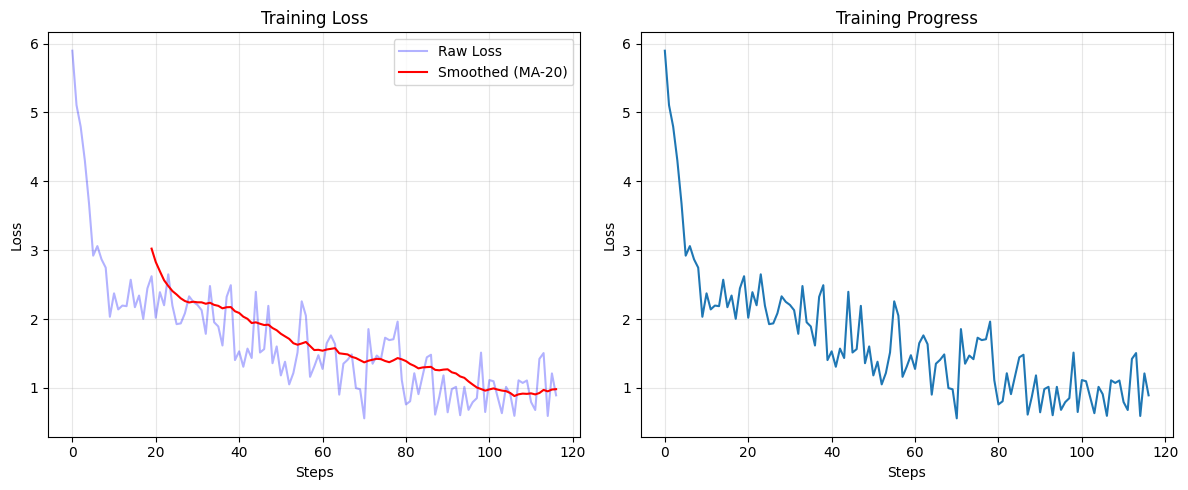

📈 Training curve tersimpan di training_curve.png


In [17]:
# Plot Training Curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses, alpha=0.3, color='blue', label='Raw Loss')
if len(losses) > 20:
    smoothed = np.convolve(losses, np.ones(20)/20, mode='valid')
    plt.plot(range(19, len(losses)), smoothed, color='red', label='Smoothed (MA-20)')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curve.png', dpi=150)
plt.show()

print("📈 Training curve tersimpan di training_curve.png")

---
## 7. Model Evaluation (LLM-based Scoring)

Evaluasi model menggunakan LLM sebagai juri untuk memberikan skor 0-10.

In [18]:
# Fungsi Chat untuk inference
def chat(question, max_new_tokens=150):
    """
    Fungsi untuk chat dengan model
    """
    model.eval()
    prompt = template_without_answer.format(question=question)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            do_sample=True,
            top_p=0.9,
            repetition_penalty=1.15,
            pad_token_id=tokenizer.eos_token_id
        )

    result = tokenizer.decode(outputs[0], skip_special_tokens=True)

    if "model\n" in result:
        return result.split("model\n")[-1].strip()
    return result.strip()

print("✅ Fungsi chat() siap!")

✅ Fungsi chat() siap!


In [19]:
# Generate jawaban untuk test set
print("🧪 Generating jawaban untuk test set...")

n_samples = 10  # Jumlah sample untuk evaluasi
generated_samples = []
reference_samples = []

for i, batch in enumerate(tqdm(test_loader, total=n_samples)):
    if i >= n_samples:
        break

    question = batch['instruction'][0]
    reference = batch['output'][0]

    answer = chat(question, max_new_tokens=100)

    generated_samples.append(answer)
    reference_samples.append(reference)

print(f"✅ Generated {len(generated_samples)} jawaban")

🧪 Generating jawaban untuk test set...


100%|██████████| 10/10 [00:13<00:00,  1.32s/it]

✅ Generated 10 jawaban


In [20]:
# LLM-based Scoring
import re

class LLMJudge:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def score(self, question, reference, answer):
        """
        Beri skor 0-10 untuk jawaban model
        """
        prompt = f"""<start_of_turn>user
Rate this answer from 0-10 based on accuracy and relevance.

Question: {question}
Reference Answer: {reference}
Model Answer: {answer}

Reply with only: SCORE: X (where X is 0-10)<end_of_turn>
<start_of_turn>model
"""
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)

        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=20,
                temperature=0.1,
                do_sample=False
            )

        response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Extract score
        match = re.search(r'SCORE:\s*(\d+)', response, re.IGNORECASE)
        if match:
            score = int(match.group(1))
            return min(max(score, 0), 10)  # Clamp to 0-10

        # Fallback: cari angka
        nums = re.findall(r'\b(10|[0-9])\b', response)
        if nums:
            return int(nums[-1])

        return 5  # Default score

judge = LLMJudge(model, tokenizer)
print("✅ LLM Judge siap!")

✅ LLM Judge siap!


In [21]:
# Evaluasi dengan LLM Judge
print("⚖️ Mengevaluasi jawaban model...")

scores = []
for i in tqdm(range(len(generated_samples))):
    question = test_dataset[i]['instruction']
    reference = reference_samples[i]
    answer = generated_samples[i]

    score = judge.score(question, reference, answer)
    scores.append(score)

# Statistik evaluasi
avg_score = np.mean(scores)
min_score = np.min(scores)
max_score = np.max(scores)

print("\n" + "="*60)
print("📊 HASIL EVALUASI")
print("="*60)
print(f"Rata-rata Skor: {avg_score:.2f} / 10")
print(f"Skor Minimum: {min_score}")
print(f"Skor Maximum: {max_score}")
print(f"Total Samples: {len(scores)}")

⚖️ Mengevaluasi jawaban model...


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


📊 HASIL EVALUASI
Rata-rata Skor: 9.00 / 10
Skor Minimum: 7
Skor Maximum: 10
Total Samples: 10


---
## 8. Model Prediction & Save Results

Generate prediksi untuk test set dan simpan ke file JSON.

In [22]:
# Pengujian 5 Skenario
print("="*70)
print("📋 PENGUJIAN 5 SKENARIO CHATBOT")
print("="*70)

test_scenarios = [
    "Apa itu gudeg kering?",
    "Dimana lokasi Sate Klathak Pak Bari?",
    "Siapa pendiri Muhammadiyah?",
    "Kapan Perang Diponegoro terjadi?",
    "Rekomendasi kuliner malam di Jogja?"
]

scenario_results = []

for i, question in enumerate(test_scenarios, 1):
    answer = chat(question, max_new_tokens=150)

    print(f"\n{'='*70}")
    print(f"🧪 SKENARIO {i}")
    print(f"{'='*70}")
    print(f"❓ Pertanyaan: {question}")
    print(f"🤖 Jawaban: {answer}")

    scenario_results.append({
        "skenario": i,
        "pertanyaan": question,
        "jawaban": answer
    })

print("\n" + "="*70)
print("✅ PENGUJIAN 5 SKENARIO SELESAI")
print("="*70)

📋 PENGUJIAN 5 SKENARIO CHATBOT

🧪 SKENARIO 1
❓ Pertanyaan: Apa itu gudeg kering?
🤖 Jawaban: Gudeg manis karena pengaruh budaya Mataram yang kaya gula. Manis melambangkan kemakmuran.

🧪 SKENARIO 2
❓ Pertanyaan: Dimana lokasi Sate Klathak Pak Bari?
🤖 Jawaban: Di sebelah timur barat alun-alun selatan Tugu.

🧪 SKENARIO 3
❓ Pertanyaan: Siapa pendiri Muhammadiyah?
🤖 Jawaban: Para pelajar STOVIA.

🧪 SKENARIO 4
❓ Pertanyaan: Kapan Perang Diponegoro terjadi?
🤖 Jawaban: 1825–1830.

🧪 SKENARIO 5
❓ Pertanyaan: Rekomendasi kuliner malam di Jogja?
🤖 Jawaban: Dekat area tersebut banyak warung lokal. Pakai Google Maps cari 'kuliner dekat saya' atau tanya warga.

✅ PENGUJIAN 5 SKENARIO SELESAI


In [23]:
# Simpan hasil prediksi ke JSON
print("💾 Menyimpan hasil prediksi...")

predictions = []
for i in range(len(generated_samples)):
    predictions.append({
        "instruction": test_dataset[i]['instruction'],
        "input": test_dataset[i].get('input', ''),
        "expected_output": reference_samples[i],
        "model_response": generated_samples[i],
        "score": scores[i] if i < len(scores) else None
    })

with open("predictions.json", "w", encoding="utf-8") as f:
    json.dump(predictions, f, ensure_ascii=False, indent=2)

print(f"✅ {len(predictions)} prediksi tersimpan di predictions.json")

# Simpan skenario
with open("test_scenarios.json", "w", encoding="utf-8") as f:
    json.dump(scenario_results, f, ensure_ascii=False, indent=2)

print("✅ Hasil skenario tersimpan di test_scenarios.json")

💾 Menyimpan hasil prediksi...
✅ 10 prediksi tersimpan di predictions.json
✅ Hasil skenario tersimpan di test_scenarios.json


---
## 9. Save & Upload Model

In [24]:
# Simpan model ke local
output_dir = "model_jogja_kuliner_sejarah"

print(f"💾 Menyimpan model ke '{output_dir}'...")
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print("✅ Model berhasil disimpan!")

💾 Menyimpan model ke 'model_jogja_kuliner_sejarah'...
✅ Model berhasil disimpan!


In [25]:
# Login ke Hugging Face
from huggingface_hub import login

print("🔐 Login ke Hugging Face...")
print("Dapatkan token di: https://huggingface.co/settings/tokens")
login()

🔐 Login ke Hugging Face...
Dapatkan token di: https://huggingface.co/settings/tokens


In [27]:
# Upload model ke Hugging Face Hub
HF_USERNAME = "JSpiritGG"  # Ganti dengan username kamu
REPO_NAME = "jogja-kuliner-chatbot"

print("📤 Uploading model ke Hugging Face Hub...")
print("⏳ Ini membutuhkan waktu beberapa menit...")

model.push_to_hub(f"{HF_USERNAME}/{REPO_NAME}")
print("✅ Model uploaded!")

tokenizer.push_to_hub(f"{HF_USERNAME}/{REPO_NAME}")
print("✅ Tokenizer uploaded!")

print(f"\n🎉 Model tersimpan di: https://huggingface.co/{HF_USERNAME}/{REPO_NAME}")

📤 Uploading model ke Hugging Face Hub...
⏳ Ini membutuhkan waktu beberapa menit...


README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:   0%|          | 41.9kB /  166MB            

✅ Model uploaded!


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...pw1i9oaef/tokenizer.model:  98%|#########8| 4.17MB / 4.24MB            

  ...mpw1i9oaef/tokenizer.json: 100%|##########| 34.4MB / 34.4MB            

No files have been modified since last commit. Skipping to prevent empty commit.


✅ Tokenizer uploaded!

🎉 Model tersimpan di: https://huggingface.co/JSpiritGG/jogja-kuliner-chatbot


---
## 10. Deployment ke Hugging Face Spaces

In [29]:
# Upload ke Space
api = HfApi()

print("📤 Uploading ke Hugging Face Space...")

for filename in ["README.md", "app.py", "requirements.txt"]:
    api.upload_file(
        path_or_fileobj=filename,
        path_in_repo=filename,
        repo_id=f"{HF_USERNAME}/{SPACE_NAME}",
        repo_type="space"
    )
    print(f"✅ {filename} uploaded")

print(f"""
{'='*60}
🎉 DEPLOYMENT SELESAI!
{'='*60}

🔗 Link Aplikasi (PERMANEN):
   https://huggingface.co/spaces/{HF_USERNAME}/{SPACE_NAME}

⏳ Tunggu 5-10 menit untuk build selesai.
{'='*60}
""")

📤 Uploading ke Hugging Face Space...
✅ README.md uploaded
✅ app.py uploaded
✅ requirements.txt uploaded

🎉 DEPLOYMENT SELESAI!

🔗 Link Aplikasi (PERMANEN):
   https://huggingface.co/spaces/JSpiritGG/jogja-kuliner-chatbot

⏳ Tunggu 5-10 menit untuk build selesai.



---
## 📊 Ringkasan Hasil

| Metrik | Nilai |
|--------|-------|
| Total Training Steps | - |
| Final Loss | - |
| Best Loss | - |
| Evaluation Score | - / 10 |

---

## 🔗 Links
- **Demo App:** https://huggingface.co/spaces/JSpiritGG/jogja-kuliner-chatbot
- **Model:** https://huggingface.co/JSpiritGG/jogja-kuliner-chatbot

---

**© 2025 - UAS Deep Learning**